In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import pandas as pd

In [2]:
POI_FILENAME = "data/poi-paris.pkl"
parismap = mpimg.imread('data/paris-48.806-2.23--48.916-2.48.jpg')
## coordonnees GPS de la carte
xmin, xmax = 2.23, 2.48  # coord_x min et max
ymin, ymax = 48.806, 48.916  # coord_y min et max
coords = [xmin, xmax, ymin, ymax]

In [3]:
def get_density2D(f,data,steps=100):
	""" Calcule la densité en chaque case d'une grille steps x steps dont les bornes sont calculées à partir du min/max de data. Renvoie 
	la grille estimée et la discrétisation sur chaque axe.
	"""
	xmin, xmax = data[:,0].min(), data[:,0].max()
	ymin, ymax = data[:,1].min(), data[:,1].max()
	xlin,ylin = np.linspace(xmin,xmax,steps),np.linspace(ymin,ymax,steps)
	xx, yy = np.meshgrid(xlin,ylin)
	grid = np.c_[xx.ravel(), yy.ravel()]
	res = f.predict(grid).reshape(steps, steps)
	return res, xlin, ylin

def show_density(f, data, steps=100, log=False):
	""" Dessine la densité f et ses courbes de niveau sur une grille 2D calculée à partir de data, avec un pas de discrétisation de steps. Le paramètre log permet d'afficher la log densité plutôt que la densité brute
	"""
	res, xlin, ylin = get_density2D(f, data, steps)
	xx, yy = np.meshgrid(xlin, ylin)
	plt.figure()
	show_img()
	if log:
		res = np.log(res+1e-10)
	plt.scatter(data[:, 0], data[:, 1], alpha=0.8, s=3)
	show_img(res)
	plt.colorbar()
	plt.contour(xx, yy, res, 20)


def show_img(img=parismap):
	""" Affiche une matrice ou une image selon les coordonnées de la carte de Paris.
	"""
	origin = "lower" if len(img.shape) == 2 else "upper"
	alpha = 0.3 if len(img.shape) == 2 else 1.
	plt.imshow(img, extent=coords, aspect=1.5, origin=origin, alpha=alpha)
	## extent pour controler l'echelle du plan


def load_poi(typepoi,fn=POI_FILENAME):
	""" Dictionaire POI, clé : type de POI, valeur : dictionnaire des POIs de ce type : (id_POI, [coordonnées, note, nom, type, prix])

	Liste des POIs : furniture_store, laundry, bakery, cafe, home_goods_store, 
	clothing_store, atm, lodging, night_club, convenience_store, restaurant, bar
	"""
	poidata = pickle.load(open(fn, "rb"))
	data = np.array([[v[1][0][1],v[1][0][0]] for v in sorted(poidata[typepoi].items())])
	note = np.array([v[1][1] for v in sorted(poidata[typepoi].items())])
	return data,note

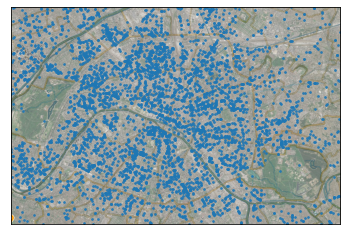

In [4]:
plt.ion()
# Liste des POIs : furniture_store, laundry, bakery, cafe, home_goods_store, clothing_store, atm, lodging, night_club, convenience_store, restaurant, bar
# La fonction charge la localisation des POIs dans geo_mat et leur note.
geo_mat, notes = load_poi("bar")

# Affiche la carte de Paris
show_img()
# Affiche les POIs
plt.scatter(geo_mat[:,0],geo_mat[:,1],alpha=0.8,s=3)
plt.xticks([])
plt.yticks([])
plt.show()

In [35]:
class Density(object):
	def fit(self,data):
		pass
	def predict(self,data):
		pass
	def score(self,data):
		# data.shape = (n,d)
		eps = 10e-10
		density = self.predict(data) + eps	# vector (n,1)
		return np.sum(np.log(density))


class Histogramme(Density):
	def __init__(self,steps=10):
		Density.__init__(self)
		self.steps = steps

	def fit(self,x):
		#A compléter : apprend l'histogramme de la densité sur x
		self.hist = np.histogramdd(x, bins=[self.steps for _ in range(x.shape[1])])
		self.delta = np.array([self.hist[1][i][1] - self.hist[1][i][0] for i in range(x.shape[1])])

	def predict(self,x):
		def to_bin(xi):
			pos = []
			for d, xii in enumerate(xi):
				for i in range(self.hist[1][d].shape[0]):
					if xii < self.hist[1][d][i]:
						break
				if i > 0:
					i -= 1
				pos.append(i)
			return tuple(pos)

		density = []
		for xi in x:
			pos = to_bin(xi)
			# print(pos)
			density.append(self.hist[0][pos] / x.shape[0] / np.prod(self.delta))
		return np.array(density)


class KernelDensity(Density):
	def __init__(self,kernel=None,sigma=0.1):
		Density.__init__(self)
		self.kernel = kernel
		self.sigma = sigma
	def fit(self,x):
		self.x = x
	def predict(self,data):
		#A compléter : retourne la densité associée à chaque point de data
		pass

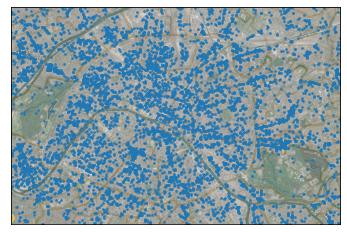

In [7]:
plt.ion()
# Liste des POIs : furniture_store, laundry, bakery, cafe, home_goods_store, clothing_store, atm, lodging, night_club, convenience_store, restaurant, bar
# La fonction charge la localisation des POIs dans geo_mat et leur note.
geo_mat, notes = load_poi("restaurant")

# Affiche la carte de Paris
show_img()
# Affiche les POIs
plt.scatter(geo_mat[:,0],geo_mat[:,1],alpha=0.8,s=3)
plt.xticks([])
plt.yticks([])
plt.show()


In [11]:
np.histogramdd(geo_mat, bins=10)

(array([[ 29.,  93., 155.,  81.,   1.,  11.,  68., 121.,  86.,  60.],
        [ 29.,  97.,  55.,  87.,  97.,  49.,  32.,  78.,  54.,  38.],
        [ 45.,  70., 103., 101.,  66., 131., 154.,  84., 101.,  68.],
        [ 55.,  94., 105., 101.,  42.,  64.,  75., 119.,  79.,  20.],
        [ 43.,  57.,  82.,  99., 111., 124., 112., 157.,  80.,  49.],
        [ 61., 114.,  64.,  48.,  96., 129.,  86.,  86.,  44.,  32.],
        [ 75.,  40.,  95., 103.,  93.,  96.,  79., 116., 101.,  66.],
        [ 64.,  76.,  19.,  99.,  77.,  41.,  90.,  40.,  35.,  14.],
        [ 43.,   4.,   6., 105.,  65.,  71.,  34.,  39.,  19.,  54.],
        [ 64.,  36.,  15.,  48.,  32.,  19.,  75.,  29.,  36.,  29.]]),
 [array([2.2300503 , 2.25503982, 2.28002934, 2.30501886, 2.33000838,
         2.3549979 , 2.37998742, 2.40497694, 2.42996646, 2.45495598,
         2.4799455 ]),
  array([48.8060263 , 48.81701915, 48.828012  , 48.83900485, 48.8499977 ,
         48.86099055, 48.8719834 , 48.88297625, 48.8939691 , 48

In [23]:
geo_mat[(1,1)] == geo_mat[1,1]

True

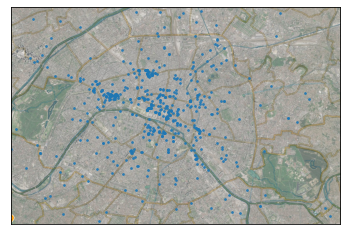

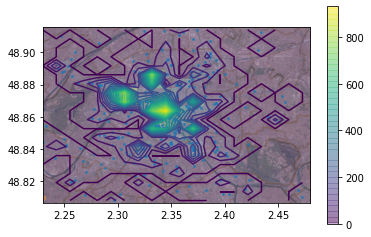

In [47]:
plt.ion()
# Liste des POIs : furniture_store, laundry, bakery, cafe, home_goods_store, clothing_store, atm, lodging, night_club, convenience_store, restaurant, bar
# La fonction charge la localisation des POIs dans geo_mat et leur note.
geo_mat, notes = load_poi("night_club")

# Affiche la carte de Paris
show_img()
# Affiche les POIs
plt.scatter(geo_mat[:,0],geo_mat[:,1],alpha=0.8,s=3)
plt.xticks([])
plt.yticks([])

steps = 20

f = Histogramme(steps)
f.fit(geo_mat)
show_density(f, geo_mat, steps)
plt.show()

In [50]:
limit = geo_mat.shape[0] // 8
X_train, X_test = geo_mat[limit:], geo_mat[:limit]
l = (1, 10,20,40,50,100)

for steps in l:
	f = Histogramme(steps)
	f.fit(X_train)
	print(steps, f.score(X_test))



1 387.30694181028383
10 407.44640584312754
20 264.4223741171605
40 -29.1386705561413
50 -212.36263670517036
100 -561.4025793420218


In [ ]:
# En testant plusieurs combinaison de data / steps / ratio de train test on constate que un petit nombre de steps donne la meilleure score pour les
# petites donnes
# En revanche, pour les plus grandes donnes, un grand nombre de steps a meilleure performance